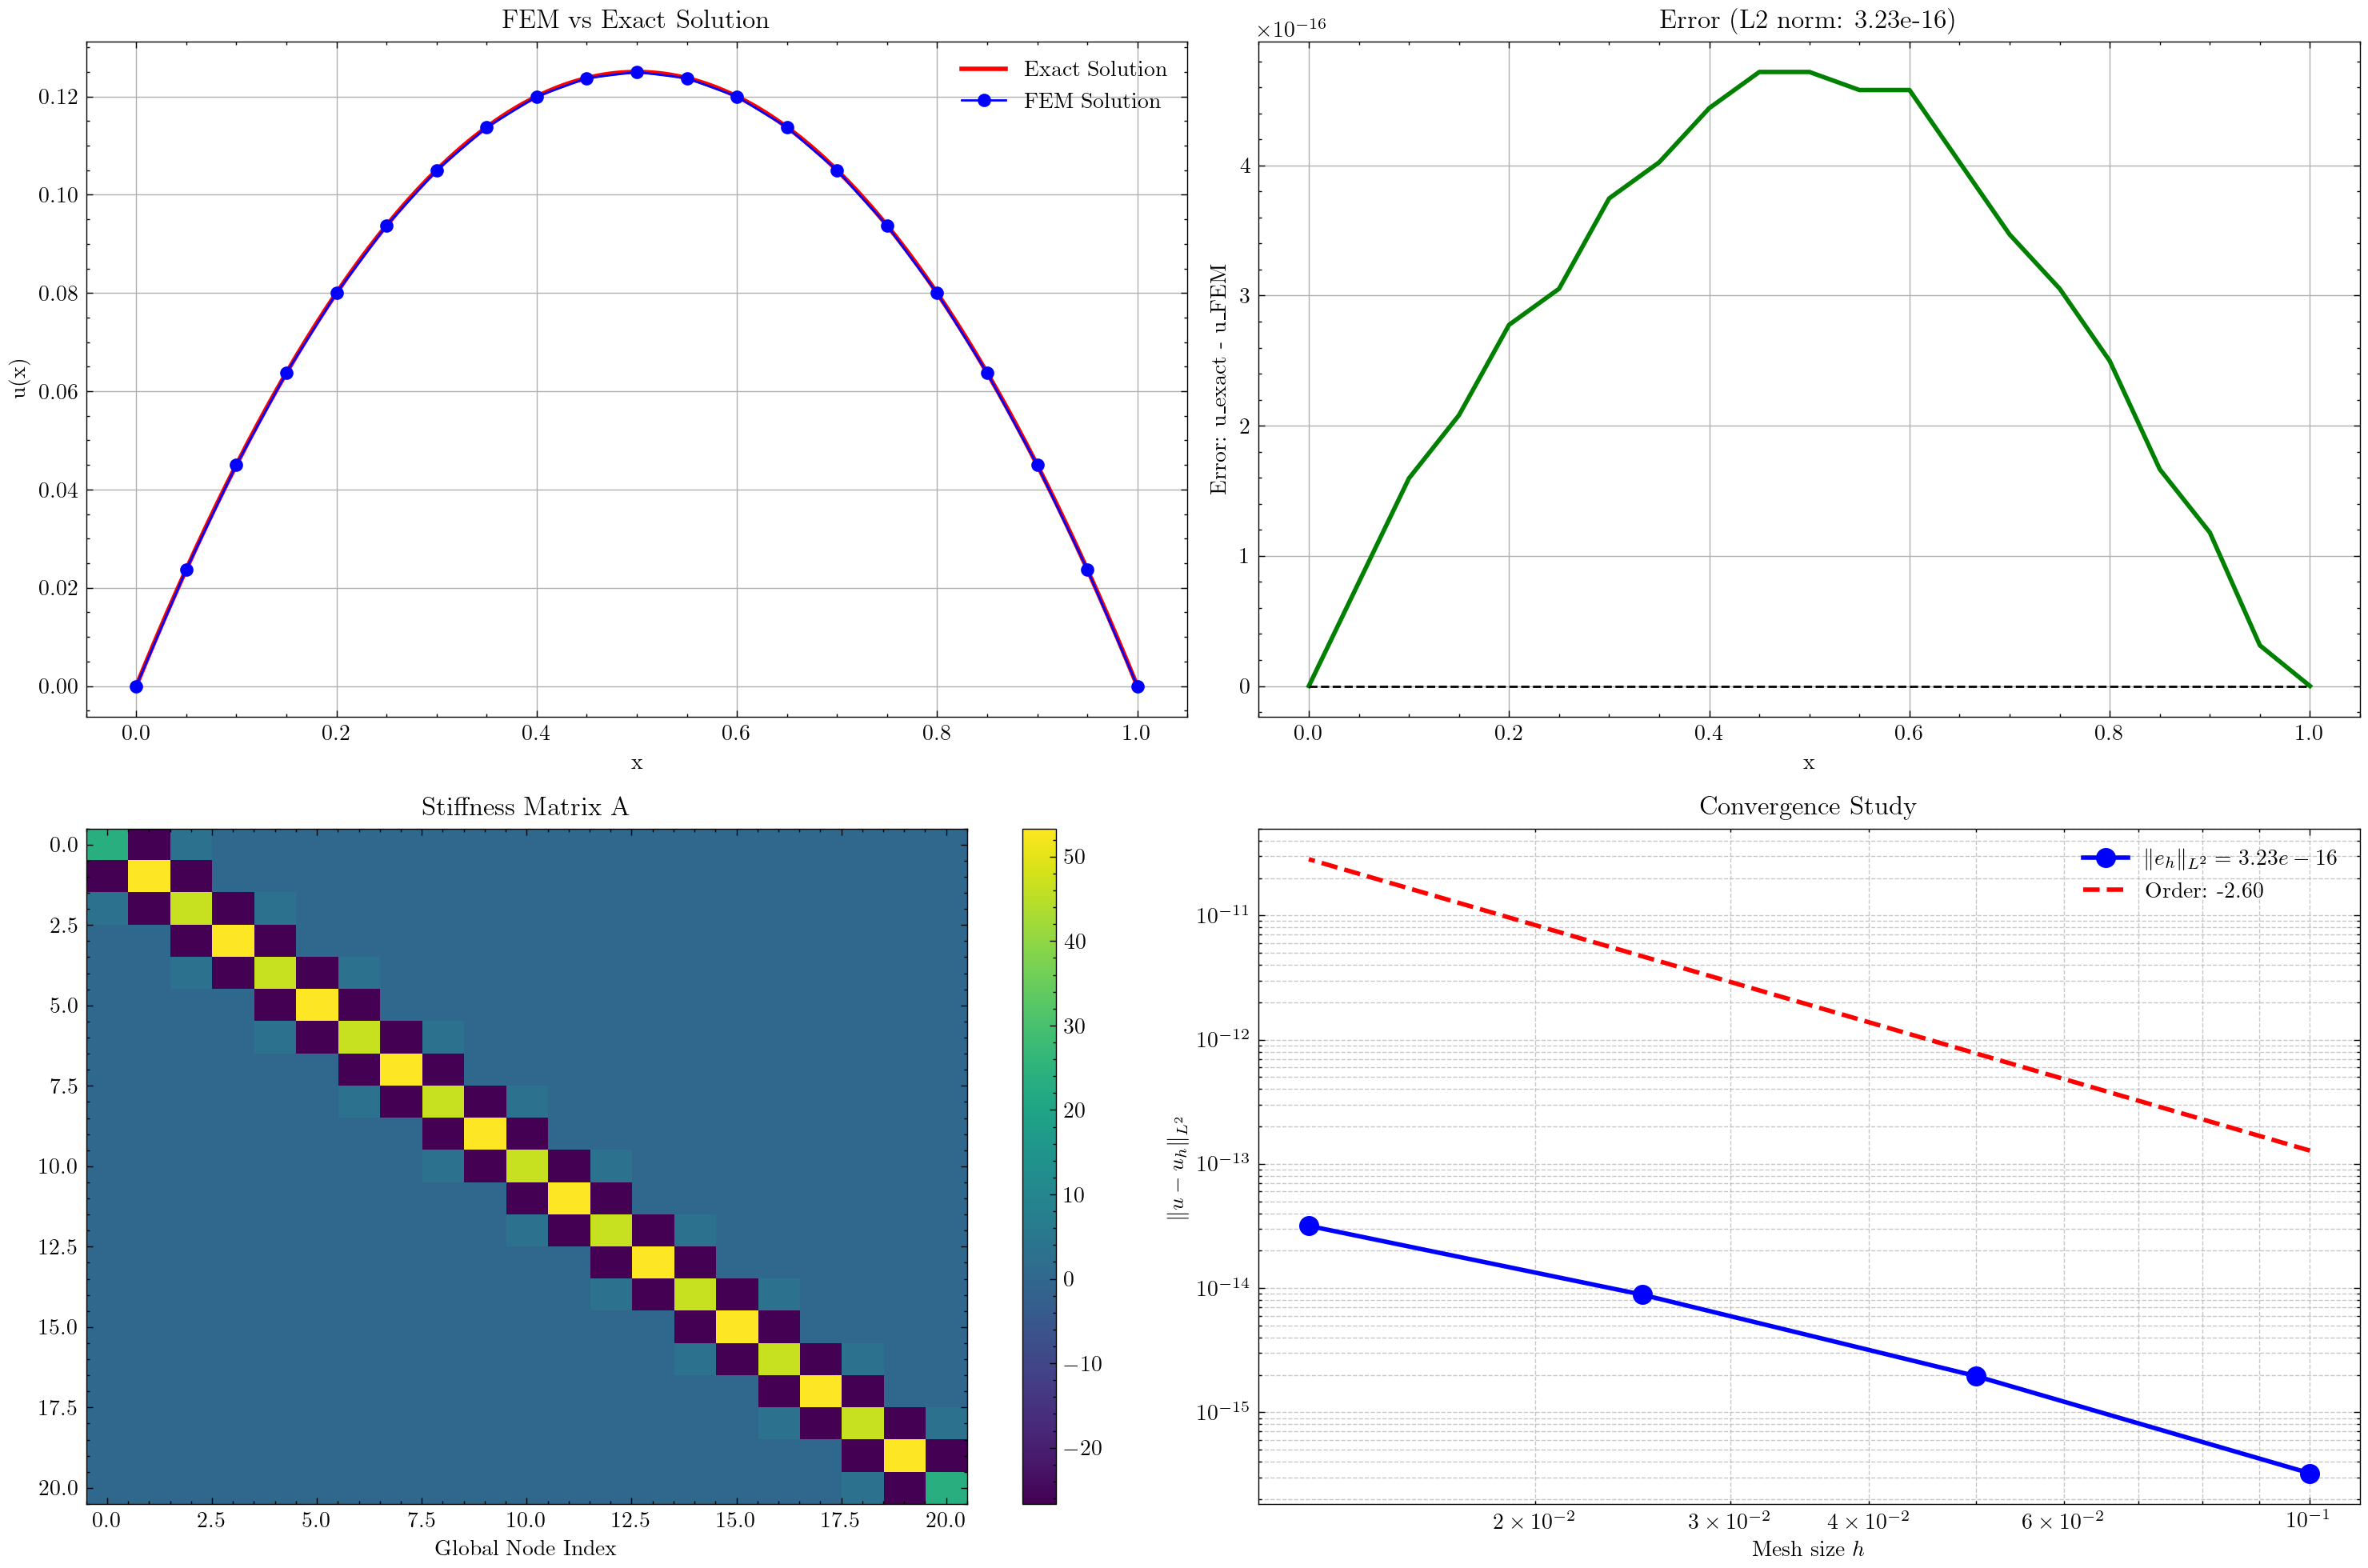

L2 Error (Test 1): 3.2329028281600044e-16


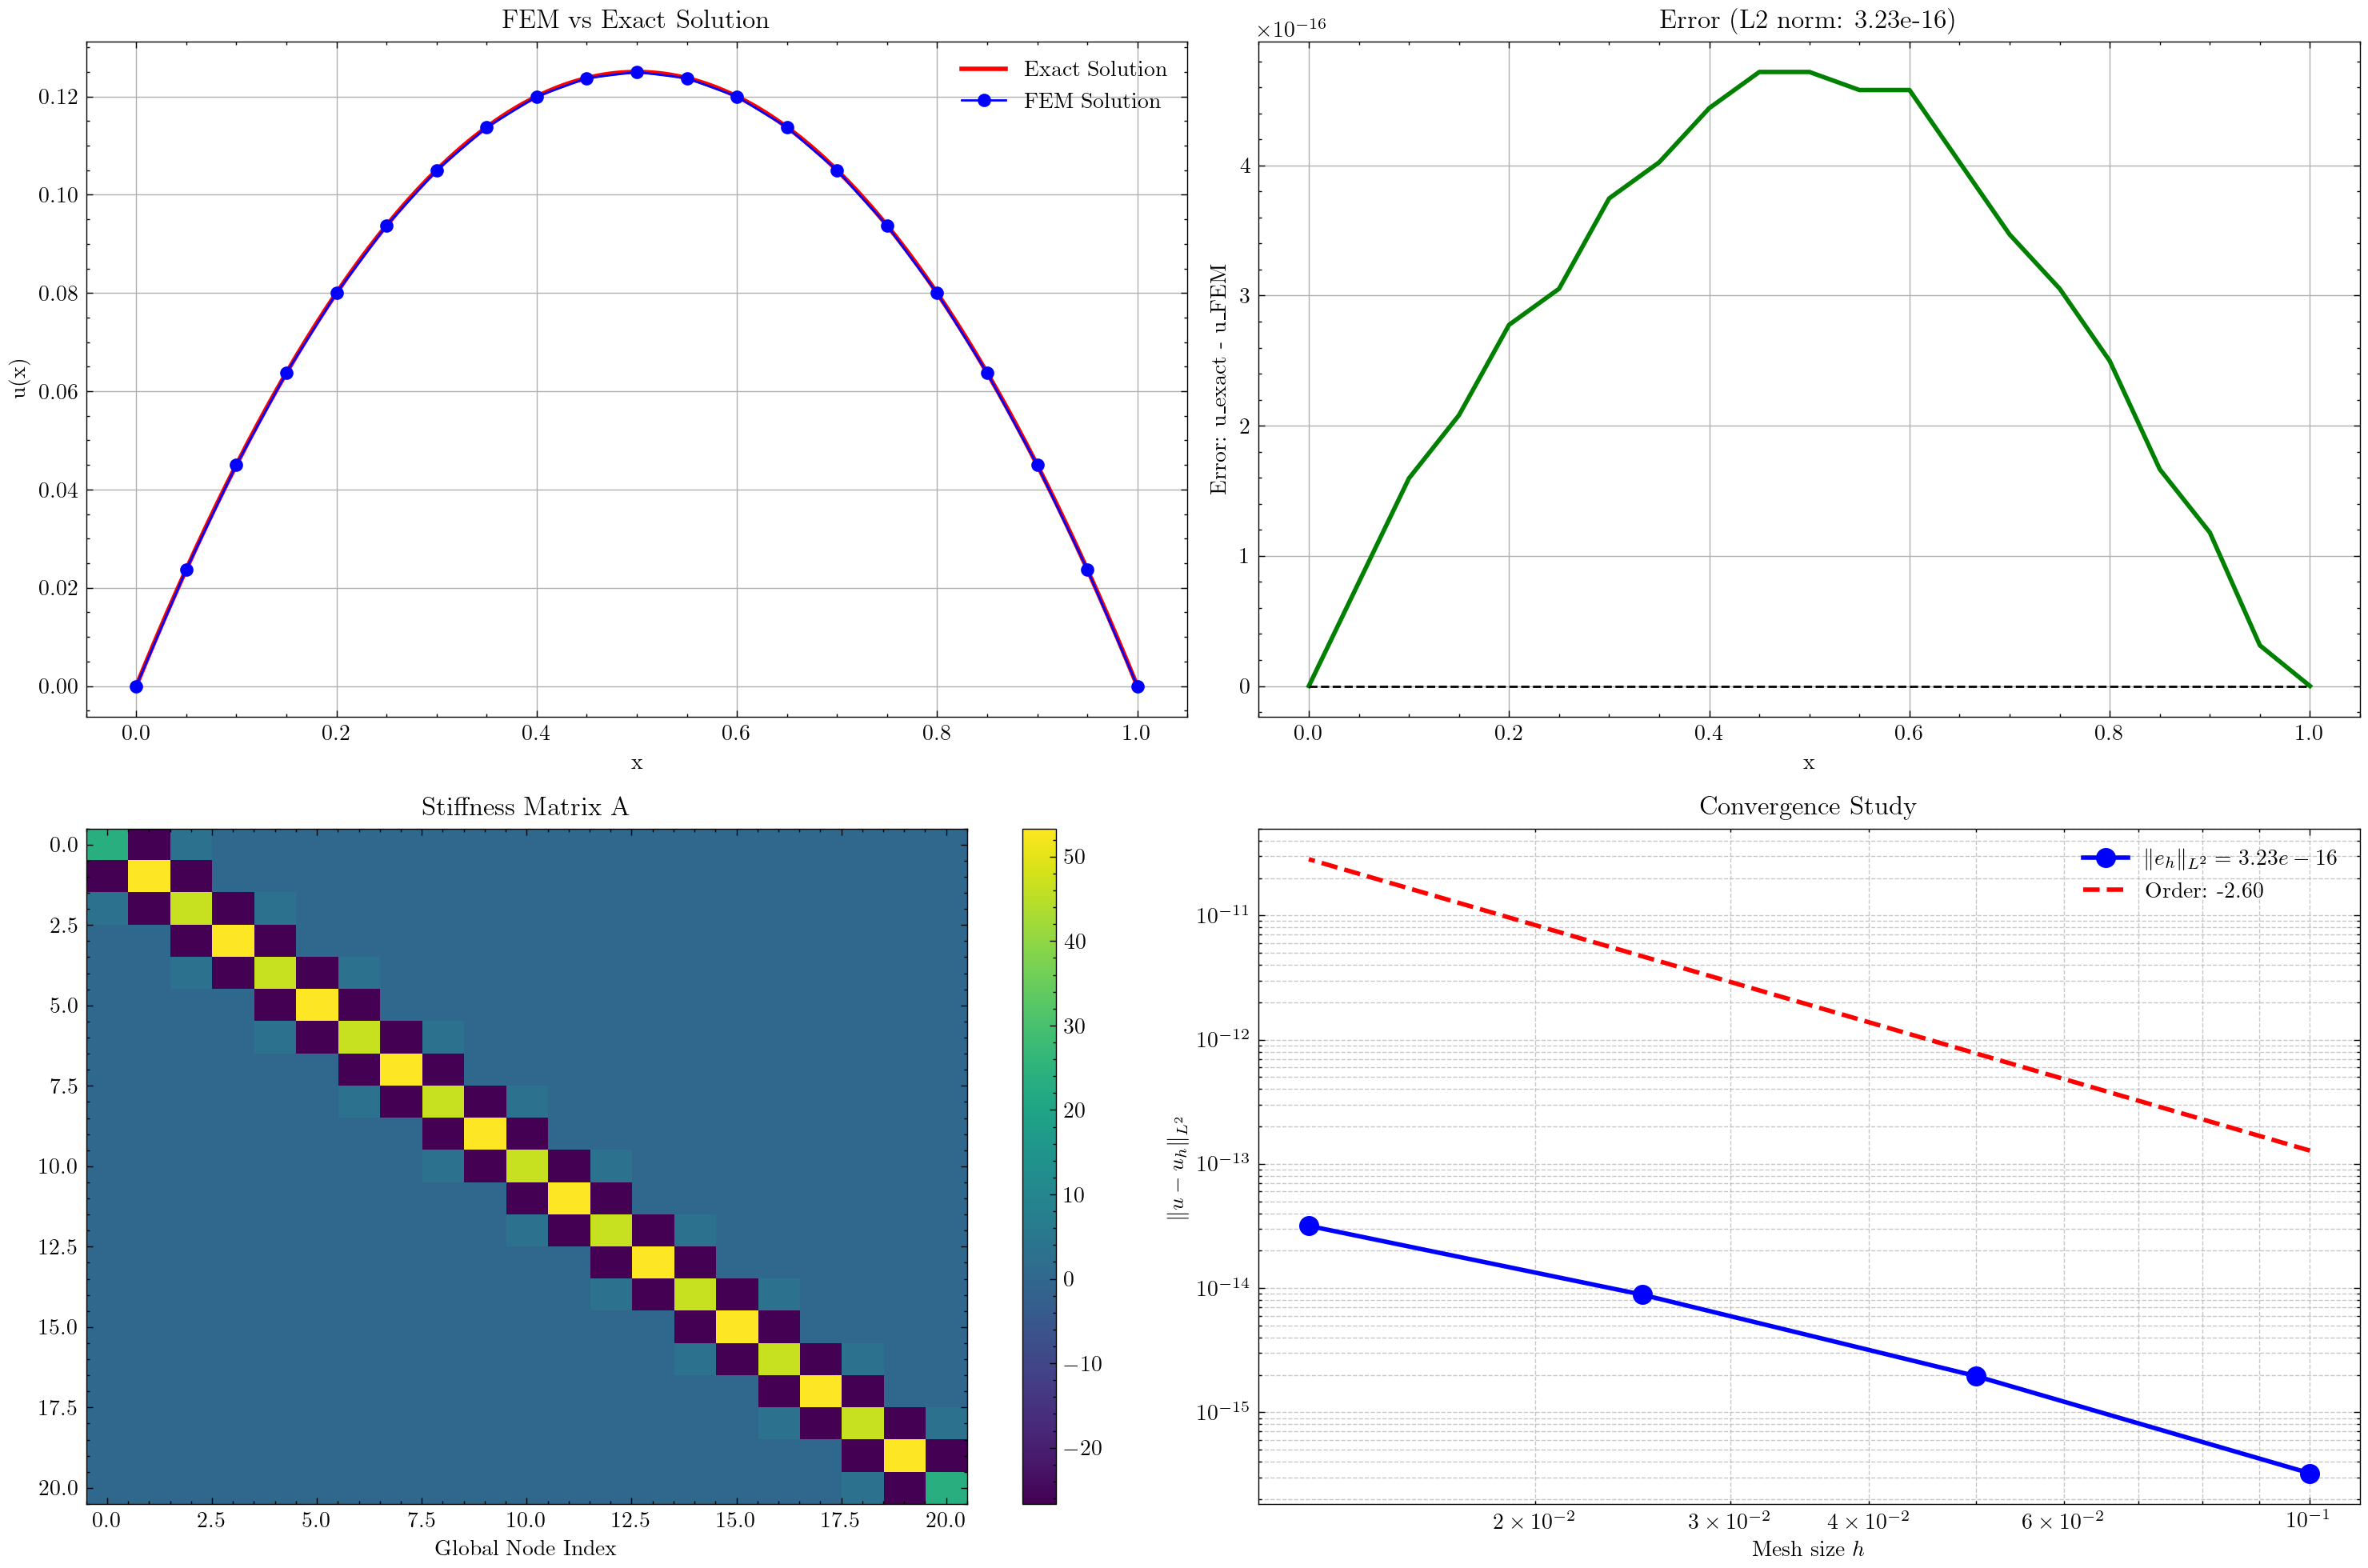

L2 Error (Test 5): 9.182822952636404e-06


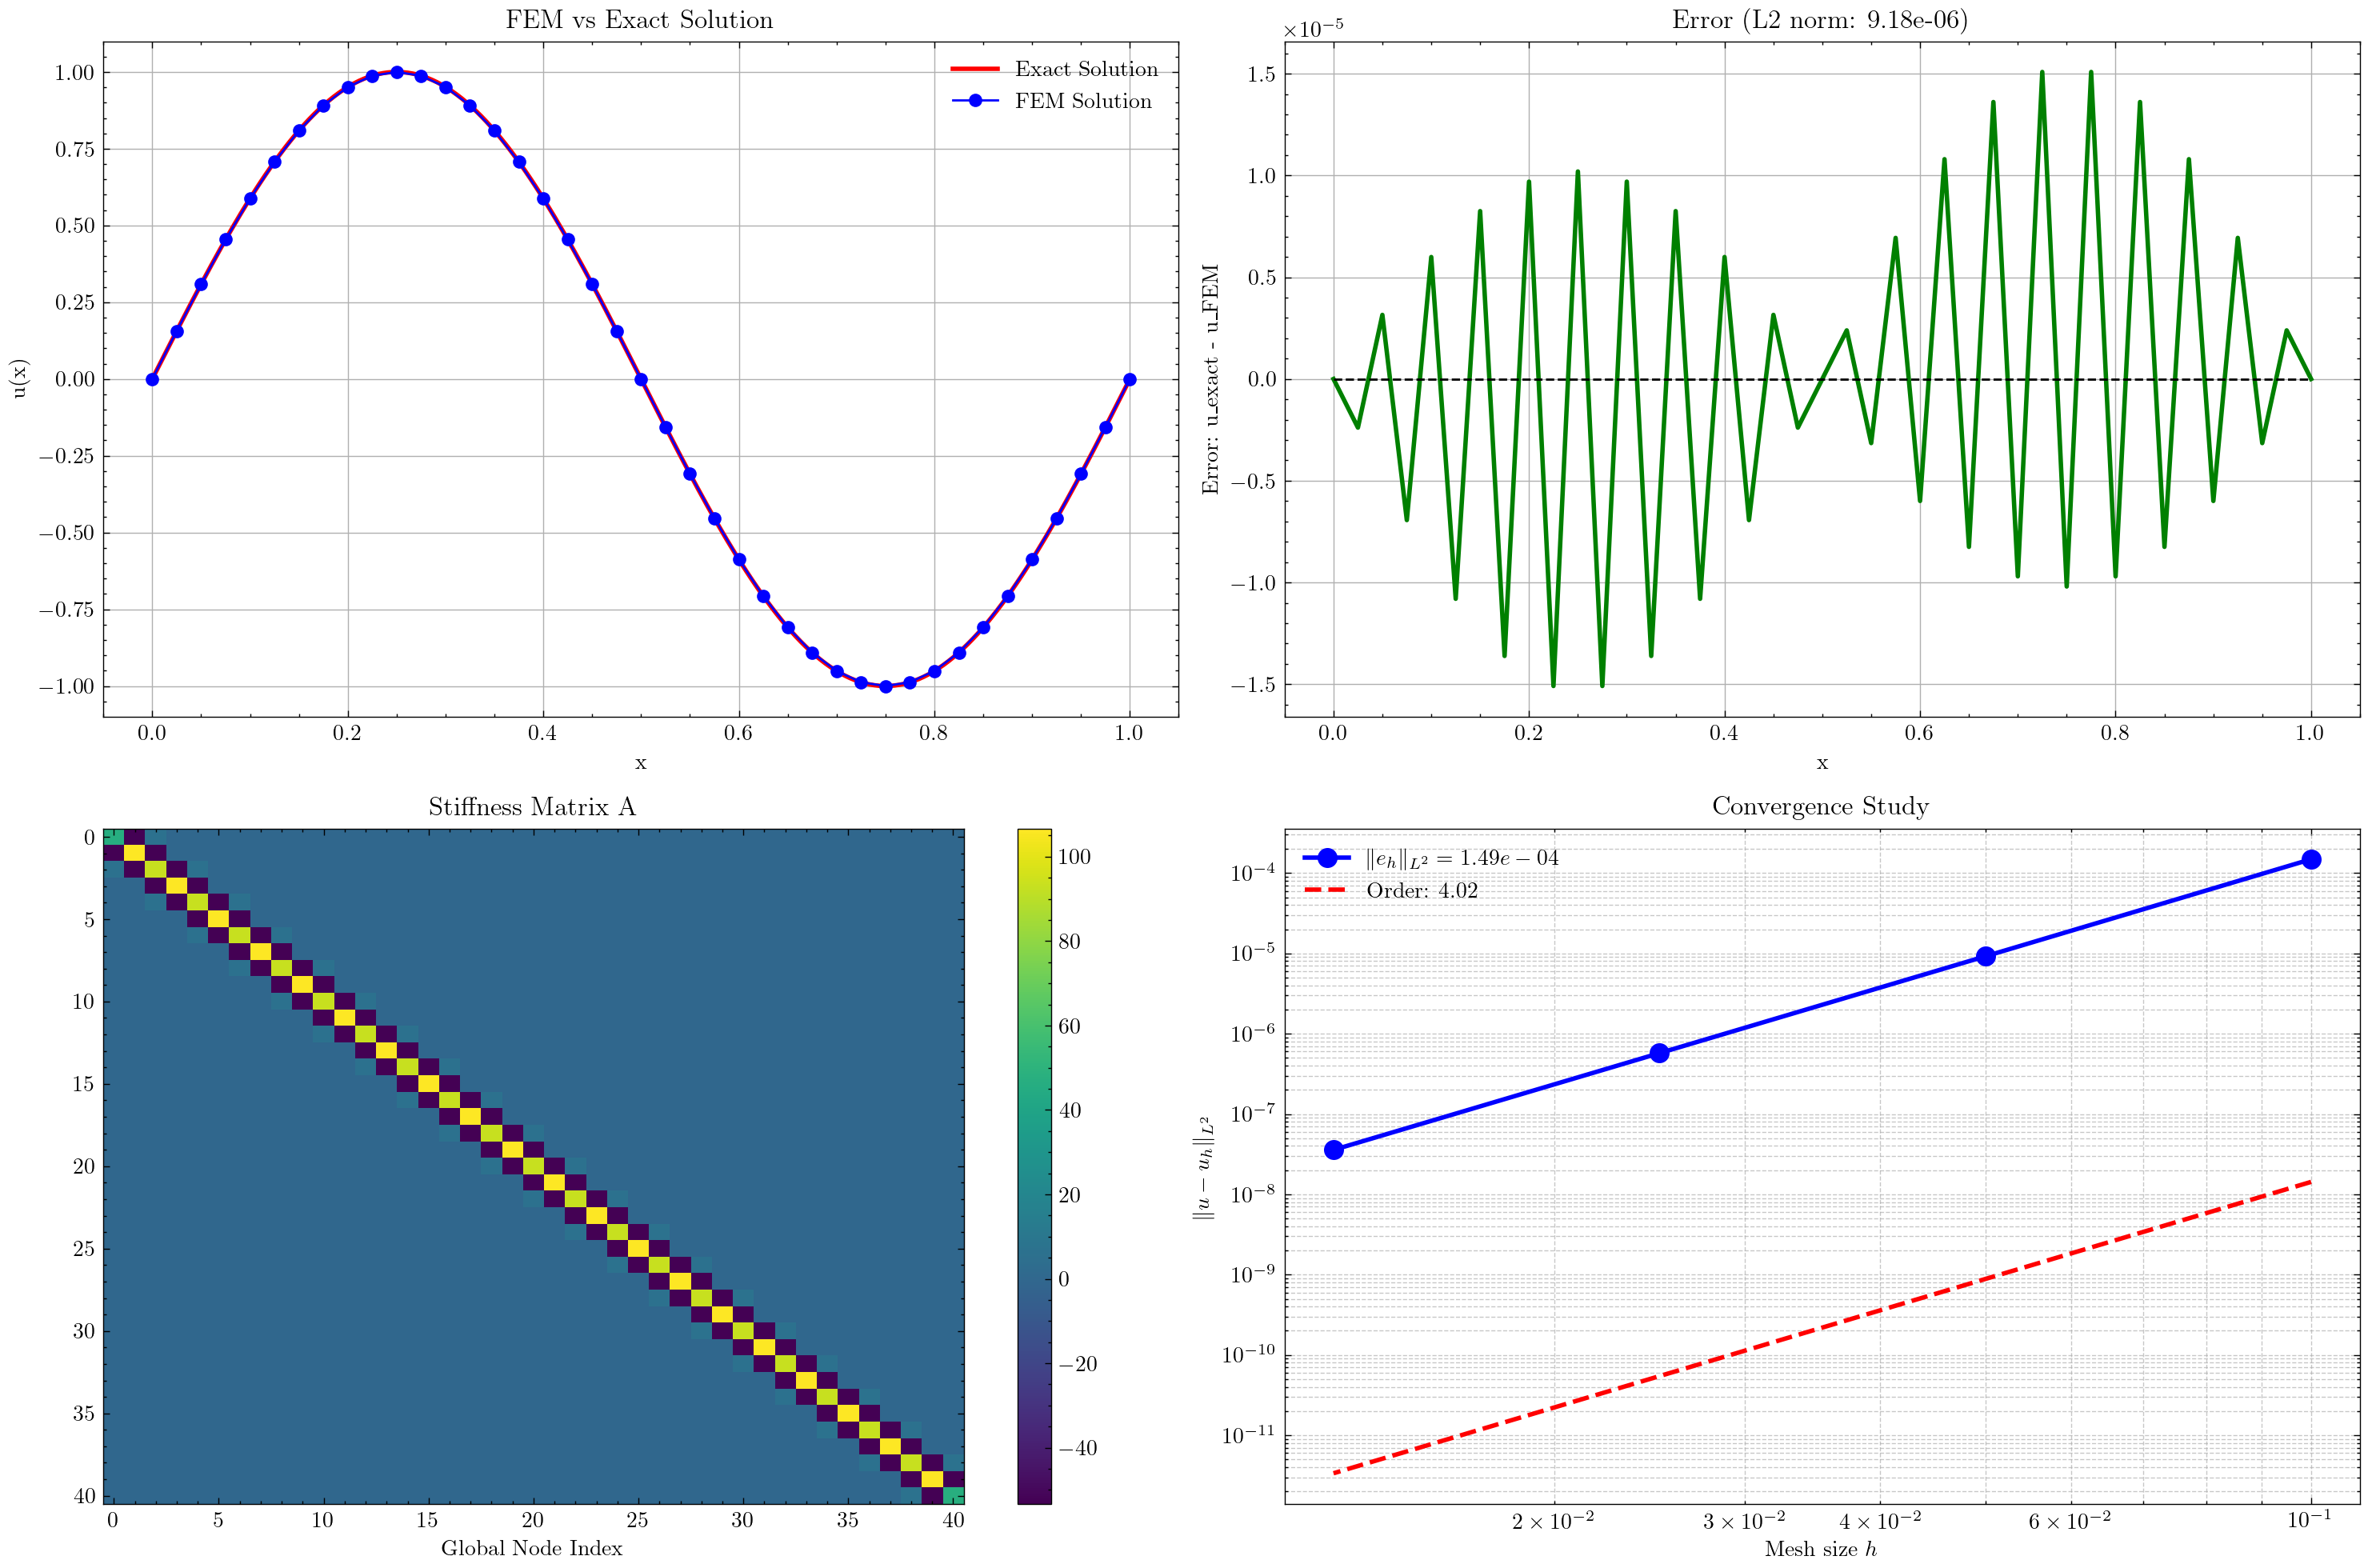

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')


class FEMPoissonSolver:
    def __init__(self, M, f, exact):
        # M: number of elements; f: forcing function; exact: exact solution (for error computation)
        self.M = M
        self.f = f
        self.exact = exact
        self.h = 1.0 / M
        self.N = 2 * M + 1  # quadratic elements: 2*M+1 nodes on [0,1]
        self.nodes = np.linspace(0, 1, self.N)
    
        self.I_ref = np.array([[7/3, -8/3,  1/3],
                               [-8/3, 16/3, -8/3],
                               [ 1/3, -8/3,  7/3]])
        # Simpson quadrature on [0,1] for local load integrals
        self.xi_quad = np.array([0.0, 0.5, 1.0])
        self.w_quad  = np.array([1/6, 4/6, 1/6])
        self.A = np.zeros((self.N, self.N))
        self.F = np.zeros(self.N)

    @staticmethod
    def phi(i, xi):
        # Quadratic Lagrange basis on reference element with nodes 0, 0.5, 1.
        if i == 0:
            return 2*xi**2 - 3*xi + 1
        elif i == 1:
            return -4 *xi**2 + 4*xi
        elif i == 2:
            return 2 * xi**2 - xi

    def assemble(self):
        for k in range(self.M):
            indices = np.array([2*k, 2*k+1, 2*k+2])
            h_k = self.nodes[indices[-1]] - self.nodes[indices[0]] 
            A_loc = (1 / h_k) * self.I_ref  # local stiffness matrix
            b_loc = np.zeros(3)
            x_left = self.nodes[indices[0]]
            # Compute local load vector using Simpson’s rule
            for q, xi in enumerate(self.xi_quad):
                x_q = x_left + h_k * xi
                for i in range(3):
                    b_loc[i] += self.w_quad[q] * self.f(x_q) * self.phi(i, xi)
            b_loc *= h_k
            # Assemble local contributions
            for a in range(3):
                self.A[indices[a], indices] += A_loc[a, :]
                self.F[indices[a]] += b_loc[a]
        # Dirichlet BC: u(0)=0 and u(1)=0.
        free = np.arange(1, self.N - 1)
        self.free = free
        self.A_reduced = self.A[free][:, free]
        self.F_reduced = self.F[free]

    def solve(self):
        self.u_free = np.linalg.solve(self.A_reduced, self.F_reduced)
        self.u = np.zeros(self.N)
        self.u[self.free] = self.u_free
        return self.u

    def L2_error(self):
        delta = self.h / 2
        error_sq = 0
        for i in range(self.N):
            err = self.exact(self.nodes[i]) - self.u[i]
            weight = 0.5 if (i == 0 or i == self.N - 1) else 1.0
            error_sq += weight * err**2
        return np.abs(np.sqrt(error_sq * delta))
    
    def plot(self, fine_mesh=200):
        """
        Create helpful visualization plots for the FEM solution
        
        Parameters:
        -----------
        fine_mesh : int
            Number of points to use for a finer mesh when plotting exact solution
        """
        # Create a figure with multiple subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10), dpi=200)
        
        # Plot 1: FEM solution vs exact solution
        x_fine = np.linspace(0, 1, fine_mesh)
        u_exact = np.array([self.exact(x) for x in x_fine])
        
        axs[0, 0].plot(x_fine, u_exact, 'r-', linewidth=2, label='Exact Solution')
        axs[0, 0].plot(self.nodes, self.u, 'bo-', markersize=5, label='FEM Solution')
        axs[0, 0].set_title('FEM vs Exact Solution')
        axs[0, 0].set_xlabel('x')
        axs[0, 0].set_ylabel('u(x)')
        axs[0, 0].legend()
        axs[0, 0].grid(True)
        
        # Plot 2: Error plot
        error = np.array([self.exact(x) - self.u[i] for i, x in enumerate(self.nodes)])
        axs[0, 1].plot(self.nodes, error, 'g-', linewidth=2)
        axs[0, 1].plot(self.nodes, np.zeros_like(self.nodes), 'k--', linewidth=1)
        axs[0, 1].set_title(f'Error (L2 norm: {self.L2_error():.2e})')
        axs[0, 1].set_xlabel('x')
        axs[0, 1].set_ylabel('Error: u_exact - u_FEM')
        axs[0, 1].grid(True)
        
        # Plot 3: Stiffness matrix visualization
        im = axs[1, 0].imshow(self.A, cmap='viridis', aspect='auto', interpolation='nearest')
        axs[1, 0].set_xlabel('Global Node Index')
        axs[1, 0].set_title('Stiffness Matrix A')
        plt.colorbar(im, ax=axs[1, 0])
        
        # Plot 4: Convergence study for different mesh sizes
        M_vals = [10, 20, 40, 80]
        errors = []
        hs = []
        
        # Store current M to avoid recomputation
        current_M = self.M
        current_u = self.u.copy()
        
        for M in M_vals:
            temp_solver = FEMPoissonSolver(M, self.f, self.exact)
            temp_solver.assemble()
            temp_solver.solve()
            errors.append(temp_solver.L2_error())
            hs.append(1.0/M)
        
        hs = np.array(hs)
        errors = np.array(errors)
        ref_slope = np.log(errors[0] / errors[1]) / np.log(hs[0] / hs[1])
              
        axs[1, 1].loglog(hs, errors, 'bo-', linewidth=2, markersize=8, label=f'$\\|e_h\\|_{{L^2}} = {errors[0]:.2e}$')
        axs[1, 1].loglog(hs, hs**ref_slope * errors[0], 'r--', linewidth=2, label=f'Order: {ref_slope:.2f}')
        axs[1, 1].set_xlabel('Mesh size $h$')
        axs[1, 1].set_ylabel('$\\|u - u_h\\|_{L^2}$')
        axs[1, 1].grid(True, which='both', ls='--', alpha=0.7)
        axs[1, 1].legend()
        axs[1, 1].set_title('Convergence Study')
        
        plt.tight_layout()
        plt.show()


# Example usage:
M = 10
f = lambda x: 1.0
exact = lambda x: 0.5 * x * (1 - x)
solver = FEMPoissonSolver(M, f, exact)
solver.assemble()
solver.solve()
solver.plot(fine_mesh=200)

# Test Example 1: Constant forcing function
f1 = lambda x: 1.0
exact1 = lambda x: 0.5 * x * (1 - x)
solver1 = FEMPoissonSolver(M=10, f=f1, exact=exact1)
solver1.assemble()
solver1.solve()
print("L2 Error (Test 1):", solver1.L2_error())
solver1.plot()

f2 = lambda x: 4*np.pi**2 * np.sin(2*np.pi*x)
exact2 = lambda x: np.sin(2*np.pi*x)
solver2 = FEMPoissonSolver(M=20, f=f2, exact=exact2)
solver2.assemble()
solver2.solve()
print("L2 Error (Test 5):", solver2.L2_error())
solver2.plot()


In [ ]:
import numpy as np


def f(x):
    return np.pi**2 * np.sin(np.pi * x)


x_nodes = np.array([0.0, 0.2, 0.5, 0.7, 1.0])  # example non-uniform mesh
N = len(x_nodes) - 1

# Assign global indices for interior node and midpoint DoFs
node_index = [-1] * (N + 1)
mid_index = [None] * N
glob_idx = 0

for j in range(1, N):  # interior nodes
    node_index[j] = glob_idx
    glob_idx += 1
for i in range(N):  # midpoints
    mid_index[i] = glob_idx
    glob_idx += 1

# Initialize global stiffness matrix K and load vector F
size = glob_idx
K = np.zeros((size, size), dtype=np.float64)
F = np.zeros(size, dtype=np.float64)

# Precomputed reference shape function values for Simpson's integration
psi_vals = {
    0: np.array([1.0, 0.0, 0.0]),
    0.5: np.array([0.0, 1.0, 0.0]),
    1: np.array([0.0, 0.0, 1.0]),
}
psi_prime = {
    0: np.array([-3.0, 4.0, -1.0]),
    0.5: np.array([-1.0, 0.0, 1.0]),
    1: np.array([1.0, -4.0, 3.0]),
}

for i in range(N):
    h_i = x_nodes[i + 1] - x_nodes[i]
    # Element stiffness via Simpson's rule on reference [0,1]:
    for a in range(3):
        for b in range(3):
            # Simpson's rule with reference shape function derivatives
            val0 = psi_prime[0][a] * psi_prime[0][b]
            valm = psi_prime[0.5][a] * psi_prime[0.5][b]
            val1 = psi_prime[1][a] * psi_prime[1][b]
            K_elem = (val0 + 4.0 * valm + val1) * (
                1.0 / (6.0 * h_i)
            )  # 1/h * (1/6)[...]
            # Map local (a, b) to global indices
            p = (
                node_index[i]
                if a == 0
                else (mid_index[i] if a == 1 else node_index[i + 1])
            )
            q = (
                node_index[i]
                if b == 0
                else (mid_index[i] if b == 1 else node_index[i + 1])
            )
            if p != -1 and q != -1:  # both are interior unknowns
                K[p, q] += K_elem
    # Element load vector via Simpson's rule
    f_left = f(x_nodes[i])
    f_mid = f((x_nodes[i] + x_nodes[i + 1]) / 2)
    f_right = f(x_nodes[i + 1])
    F_elem = np.array([f_left, 4. * f_mid, f_right]) * (h_i / 6)
    # Add to global F
    for a in range(3):
        p = node_index[i] if a == 0 else (mid_index[i] if a == 1 else node_index[i + 1])
        if p != -1:
            F[p] += F_elem[a]

# Solve KU = F for unknown coefficients U
U = np.linalg.solve(K, F)
# Plot the solution
fig = plt.figure(figsize=(10, 6), dpi=200)
ax = fig.add_subplot(111)
ax.plot(x_nodes, U[node_index], "ro-", label="FEM Solution")
x_fine = np.linspace(0, 1, 100)
u_exact = f(x_fine)
ax.plot(x_fine, u_exact, "b-", label="Exact Solution")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.set_title("FEM Solution vs Exact Solution")
ax.legend()
plt.grid()
plt.show()

In [ ]:
# Poisson Problem FEM Solver with P2 elements (Problem 1)

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from numpy.polynomial.legendre import leggauss

def generate_mesh(N):
    nodes = np.linspace(0, 1, 2 * N + 1)
    elements = [(2 * i, 2 * i + 1, 2 * i + 2) for i in range(N)]
    return nodes, elements

def reference_basis_and_derivatives():
    def psi0(x): return 2 * (x - 0.5) * (x - 1)
    def psi1(x): return 4 * x * (1 - x)
    def psi2(x): return 2 * x * (x - 0.5)
    def dpsi0(x): return 4 * x - 3
    def dpsi1(x): return 4 - 8 * x
    def dpsi2(x): return 4 * x - 1
    return [psi0, psi1, psi2], [dpsi0, dpsi1, dpsi2]

def assemble_system(N, f_func):
    nodes, elements = generate_mesh(N)
    num_dofs = len(nodes)
    A = lil_matrix((num_dofs, num_dofs))
    b = np.zeros(num_dofs)
    basis, dbasis = reference_basis_and_derivatives()
    qp, qw = leggauss(3)

    for el in elements:
        x0, x1, x2 = nodes[el[0]], nodes[el[1]], nodes[el[2]]
        h = x2 - x0
        local_A = np.zeros((3, 3))
        local_b = np.zeros(3)
        for i in range(3):
            for j in range(3):
                for k in range(len(qp)):
                    xi = 0.5 * (qp[k] + 1)
                    w = 0.5 * h * qw[k]
                    local_A[i, j] += dbasis[i](xi) * dbasis[j](xi) * w / h
        for i in range(3):
            for k in range(len(qp)):
                xi = 0.5 * (qp[k] + 1)
                x_phys = x0 + h * xi
                w = 0.5 * h * qw[k]
                local_b[i] += f_func(x_phys) * basis[i](xi) * w
        for i in range(3):
            for j in range(3):
                A[el[i], el[j]] += local_A[i, j]
            b[el[i]] += local_b[i]

    A = A[1:-1, 1:-1]
    b = b[1:-1]
    return csr_matrix(A), b, nodes[1:-1]

def solve_poisson(N, f_func):
    A, b, x = assemble_system(N, f_func)
    u_h = spsolve(A, b)
    return x, u_h

# Example: f(x) = 1, exact solution u(x) = 0.5 * x * (1 - x)
def f_example(x): return 1.0
def u_exact(x): return 0.5 * x * (1 - x)

# Run and plot
N = 20
x, u_h = solve_poisson(N, f_example)
x_fine = np.linspace(0, 1, 500)
u_ex = u_exact(x_fine)

plt.figure(figsize=(8, 4))
plt.plot(x_fine, u_ex, 'k--', label='Exact solution')
plt.plot(np.linspace(0, 1, 2 * N - 1), u_h, 'bo-', label='FEM P2 solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Poisson Problem with P2 Finite Elements')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def assemble_mass_matrix(N):
    """Assemble mass matrix M for P2 FEM."""
    nodes, elements = generate_mesh(N)
    num_dofs = len(nodes)
    M = lil_matrix((num_dofs, num_dofs))

    basis, _ = reference_basis_and_derivatives()
    qp, qw = leggauss(3)

    for el in elements:
        x0, x1, x2 = nodes[el[0]], nodes[el[1]], nodes[el[2]]
        h = x2 - x0
        local_M = np.zeros((3, 3))
        for i in range(3):
            for j in range(3):
                for k in range(len(qp)):
                    xi = 0.5 * (qp[k] + 1)
                    w = 0.5 * h * qw[k]
                    local_M[i, j] += basis[i](xi) * basis[j](xi) * w
        for i in range(3):
            for j in range(3):
                M[el[i], el[j]] += local_M[i, j]

    M = M[1:-1, 1:-1]
    return csr_matrix(M)

def interpolate_y_d(N, y_d_func):
    """Interpolate y_d at internal FEM nodes."""
    nodes, _ = generate_mesh(N)
    x = nodes[1:-1]
    return y_d_func(x)

def solve_optimal_control(N, alpha, y_d_func):
    K, _, x = assemble_system(N, f_func=None)
    M = assemble_mass_matrix(N)
    Yd = interpolate_y_d(N, y_d_func)

    A = lil_matrix((2 * len(x), 2 * len(x)))
    rhs = np.zeros(2 * len(x))

    A[:len(x), :len(x)] = M
    A[:len(x), len(x):] = alpha * K
    A[len(x):, :len(x)] = K
    A[len(x):, len(x):] = -M

    rhs[:len(x)] = M @ Yd

    A = csr_matrix(A)
    sol = spsolve(A, rhs)
    y_h = sol[:len(x)]
    u_h = sol[len(x):]
    return x, y_h, u_h

# Desired state functions
def yd_case1(x): return 0.5 * x * (1 - x)
def yd_case2(x): return np.ones_like(x)
def yd_case3(x): return np.where((x >= 0.25) & (x <= 0.75), 1.0, 0.0)

# Run and plot for each case and alpha
cases = [(yd_case1, "Case 1: yd = 0.5*x(1-x)"),
         (yd_case2, "Case 2: yd = 1"),
         (yd_case3, "Case 3: yd = step function")]

alphas = [1e-2, 1e-4, 1e-6]
N = 80

for yd_func, label in cases:
    plt.figure(figsize=(10, 4))
    for alpha in alphas:
        x, y_h, u_h = solve_optimal_control(N, alpha, yd_func)
        plt.plot(x, y_h, label=f'y_h, alpha={alpha:.0e}')
    plt.plot(x, yd_func(x), 'k--', label='y_d(x)', linewidth=1)
    plt.title(f'Optimal State y_h(x) — {label}')
    plt.xlabel('x')
    plt.ylabel('y_h(x)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    for alpha in alphas:
        x, y_h, u_h = solve_optimal_control(N, alpha, yd_func)
        plt.plot(x, u_h, label=f'u_h, alpha={alpha:.0e}')
    plt.title(f'Optimal Control u_h(x) — {label}')
    plt.xlabel('x')
    plt.ylabel('u_h(x)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

